In [2]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

<h1><center> “Good Dinner AI”</center></h1>
<h3>Use case</h3>

“As a user of Good Dinner, I can:
* post reviews in the form of comments.
* post photos taken in the restaurant.”

“As Good Dinner, I wish to:
* Detect the topics of dissatisfaction in the comments posted on the platform.
* Automatically label photos posted on the platform. For example, identifying photos related to food or decor inside or outside the restaurant.” 

<h3>Scope of the project</h3>
Preliminary study of feature “Detect the topics of dissatisfaction” and “Automatically label posted photos”

<h3>Dataset and Data Collection</h3>

* Problem: Insufficient data available on the Good Dinner platform.
* Solution: Use an existing dataset.
>> * Link to the dataset: https://www.yelp.com/dataset (Contains general information (e.g., type of cuisine) and consumer reviews of different restaurants) 
>> * To fetch new data use the yelp API

<h3> Methodology and process</h3>

* analyze the comments in order to detect topics of dissatisfaction:
>> * pre-process text data
>> * use dimension reduction techniques
>> * visualize high-dimensional data
* analyze photos in order to determine their categories 
>> * pre-process images
>> * use dimension reduction techniques
>> * visualize high-dimensional data
* collect sample collection (approximately 200 restaurants) of data via the Yelp API:
>> * retrieve only the necessary fields
>> * store the results in a usable file format (e.g., csv)
<h3>Tools</h3>

* Python and specialized NLP/CV libraries
* Jupyter Notebook and Voilà package

<h2><center>LOAD REVIEWS DATA </center></h2>

Yelp Fusion API

https://docs.developer.yelp.com/docs/fusion-intro

In [3]:
%%time
# Read the business data to merge with reviews
business_json_path = 'C:/Users/spectre/Documents/OpenClassrooms_AI/data/yelp_dataset/yelp_dataset/yelp_academic_dataset_business.json'
df_b = pd.read_json(business_json_path, lines=True)

# Filter on only open businesses 1 = open, 0 = closed
df_b = df_b[df_b['is_open']==1]
# df_b.info()

CPU times: total: 4.36 s
Wall time: 4.78 s


In [4]:
# check the data format
df_b.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.55,-90.34,3.00,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.96,-75.16,4.00,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.34,-75.47,4.50,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.27,-87.06,2.00,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '..."
6,n_0UpQx1hsNbnPUSlodU8w,Famous Footwear,"8522 Eager Road, Dierbergs Brentwood Point",Brentwood,MO,63144,38.63,-90.34,2.50,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Sporting Goods, Fashion, Shoe Stores, Shopping...","{'Monday': '0:0-0:0', 'Tuesday': '10:0-18:0', ..."


In [5]:
df_b.categories

1         Shipping Centers, Local Services, Notaries, Ma...
3         Restaurants, Food, Bubble Tea, Coffee & Tea, B...
4                                 Brewpubs, Breweries, Food
5         Burgers, Fast Food, Sandwiches, Food, Ice Crea...
6         Sporting Goods, Fashion, Shoe Stores, Shopping...
                                ...                        
150341                           Nail Salons, Beauty & Spas
150342    Pets, Nurseries & Gardening, Pet Stores, Hobby...
150343    Shopping, Jewelry, Piercing, Toy Stores, Beaut...
150344    Fitness/Exercise Equipment, Eyewear & Optician...
150345    Beauty & Spas, Permanent Makeup, Piercing, Tattoo
Name: categories, Length: 119698, dtype: object

In [8]:
%%time
# Find relevant business categories
df_cat = df_b.assign(categories = df_b.categories
                         .str.split(', ')).explode('categories')
                         
# list out the individual business categories
df_cat.categories.value_counts()
print('Total # of categories: ', len(df_cat.categories.value_counts()))
print('-------------------------------')
print('Top 10 Categories: ', df_cat.categories.value_counts()[:10])

Total # of categories:  1302
-------------------------------
Top 10 Categories:  categories
Restaurants                  34987
Food                         20419
Shopping                     20186
Home Services                13322
Beauty & Spas                12263
Health & Medical             11046
Local Services               10138
Automotive                    9879
Nightlife                     8379
Event Planning & Services     8173
Name: count, dtype: int64
CPU times: total: 1.42 s
Wall time: 1.53 s


In [9]:
# Filter business dataset to only restaurants
df_res = df_cat[df_cat['categories']=='Restaurants']
# df_res.info()

In [10]:
%%time
# There are multiple chunks to be read

chunk_list = []
# read the review dataset in chunks of size 10000
size = 10000
r_dtypes = {'review_id':str,'user_id':str,
            'business_id':str,'stars':int,
            'date':str,'text':str,'useful':int,
            'funny':int,'cool':int}

with open('C:/Users/spectre/Documents/OpenClassrooms_AI/data/yelp_dataset/yelp_dataset/yelp_academic_dataset_review.json', "r") as f:
    reader = pd.read_json(f, orient="records", lines=True, 
                          dtype=r_dtypes, chunksize=size)
    
    # use  loop to pick only relevant cols and filter data on date
    for chunk_review in reader:
        # Drop columns that aren't needed
        chunk_review = chunk_review.drop(['review_id','useful','funny','cool'], axis=1)\
                             .query("`date` >= '2017-12-01'")
        
        # Renaming column name to avoid conflict with business overall star rating
        chunk_review = chunk_review.rename(columns={'stars': 'review_stars'})
        
        # Inner merge with edited business file so only reviews related to the business remain
        chunk_merged = pd.merge(df_res, chunk_review, on='business_id', how='inner')
        
        # Show feedback on progress
        print(f"{chunk_merged.shape[0]} out of {size:,} related reviews")
        chunk_list.append(chunk_merged)

# After trimming down the review file, concatenate all relevant data back to one dataframe
df = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)

880 out of 10,000 related reviews
910 out of 10,000 related reviews
945 out of 10,000 related reviews
828 out of 10,000 related reviews
910 out of 10,000 related reviews
885 out of 10,000 related reviews
871 out of 10,000 related reviews
845 out of 10,000 related reviews
848 out of 10,000 related reviews
890 out of 10,000 related reviews
872 out of 10,000 related reviews
840 out of 10,000 related reviews
821 out of 10,000 related reviews
835 out of 10,000 related reviews
840 out of 10,000 related reviews
870 out of 10,000 related reviews
794 out of 10,000 related reviews
848 out of 10,000 related reviews
854 out of 10,000 related reviews
780 out of 10,000 related reviews
858 out of 10,000 related reviews
869 out of 10,000 related reviews
977 out of 10,000 related reviews
901 out of 10,000 related reviews
1012 out of 10,000 related reviews
1161 out of 10,000 related reviews
1277 out of 10,000 related reviews
1467 out of 10,000 related reviews
1640 out of 10,000 related reviews
1904 out 

In [13]:
%%time
# convert the reviews to two classes above avergae and below average
rev = df[['text', 'review_stars']].copy()
# df['Sentiment'] = df[df.review_stars!=3].review_stars.map(lambda score:0 if score < 3 else 1)
rev['sentiment'] = rev.review_stars.map(lambda score:0 if score <= 3 else 1)
rev = rev.drop('review_stars', axis=1)
# count the number of occurance for each sentiment class
rev.sentiment.value_counts()

CPU times: total: 1.19 s
Wall time: 1.36 s


sentiment
1    1281383
0     562355
Name: count, dtype: int64

In [19]:
df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,user_id,review_stars,text,date,Sentiment
0,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.95,-75.14,4.00,245,1,"{'RestaurantsReservations': 'True', 'Restauran...",Restaurants,"{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-...",Qsk0aTclam9W_DIK6bx42A,5,Stopped in to check out this new spot around t...,2017-12-16 00:13:06,1.00
1,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.95,-75.14,4.00,245,1,"{'RestaurantsReservations': 'True', 'Restauran...",Restaurants,"{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-...",TJW1aEzjhaxbD10fjhokfQ,1,I live in the neighborhood and used to order a...,2018-04-28 00:46:05,0.00
2,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.95,-75.14,4.00,245,1,"{'RestaurantsReservations': 'True', 'Restauran...",Restaurants,"{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-...",PYaXWwacBhNPVtXEZ1j-_w,5,We came here tonight just for a date night. We...,2018-01-10 02:56:31,1.00
3,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.95,-75.14,4.00,245,1,"{'RestaurantsReservations': 'True', 'Restauran...",Restaurants,"{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-...",T9b7lYhNTAr7PyL4x8mmIw,5,Wow! What a great dining adventure! Huge rolls...,2017-12-29 23:57:16,1.00
4,kV_Q1oqis8Qli8dUoGpTyQ,Ardmore Pizza,10 Rittenhouse Pl,Ardmore,PA,19003,40.01,-75.29,3.50,109,1,"{'RestaurantsGoodForGroups': 'True', 'WiFi': '...",Restaurants,"{'Monday': '11:0-0:0', 'Tuesday': '11:0-0:0', ...",XOa3fuOw90GWvghLHyTQYA,2,Bunch of high school/college kids running the ...,2018-08-05 00:10:12,0.00


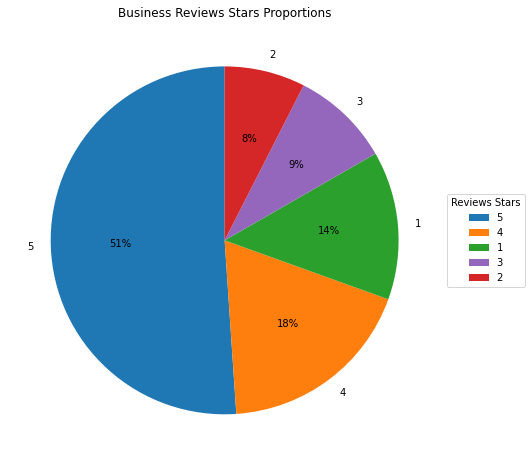

In [20]:
# Exploratory Data Analysis: Category Distribution
import matplotlib.pyplot as plt
label_dist = df.groupby('review_stars')['business_id'].count().sort_values(ascending=False).to_frame().reset_index()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:red']

fig, ax = plt.subplots(figsize=(10, 8))
fig.patch.set_facecolor('white')

ax.pie(label_dist.business_id, 
        labels = label_dist.review_stars, 
        colors = colors,
        startangle = 90,
        autopct = '%.0f%%',
        textprops=dict(color="black"))

# Adding legend
ax.legend(label_dist.review_stars, 
          title="Reviews Stars",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
ax.set_title('Business Reviews Stars Proportions')
plt.show()

In [31]:
#Take a sample of the data
sample = rev.sample(100000)
sample

,text,sentiment
1212396,Can't go wrong with Chick-Fil-A food. Service ...,1
898957,Horrible place!!!! Waited 20 min at a table in...,0
36057,This is a great stop over and a memorable expe...,1
1355947,Got three tacos and a bean and cheese burrito....,0
1389579,We were able to eat inside!! We stuck with our...,1
...,...,...
509719,Caught happy hour here the other day (4-6 PM)....,1
1360545,What a fantastic birthday dinner! French onio...,1
1029316,"Great food, totally exceeded my expectations. ...",1
163445,So the first time we ordered from them we got ...,0


In [32]:
%%time 
# Tokenize the corpus
from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize import RegexpTokenizer # use regex tokenizer

tokenizer = RegexpTokenizer(r'[A-Za-z]+')
# Tokenize the reviews
sample['text'] = sample.text.map(lambda x:tokenizer.tokenize(x))
sample

CPU times: total: 4.48 s
Wall time: 6.35 s


,text,sentiment
1212396,"[Can, t, go, wrong, with, Chick, Fil, A, food,...",1
898957,"[Horrible, place, Waited, min, at, a, table, i...",0
36057,"[This, is, a, great, stop, over, and, a, memor...",1
1355947,"[Got, three, tacos, and, a, bean, and, cheese,...",0
1389579,"[We, were, able, to, eat, inside, We, stuck, w...",1
...,...,...
509719,"[Caught, happy, hour, here, the, other, day, P...",1
1360545,"[What, a, fantastic, birthday, dinner, French,...",1
1029316,"[Great, food, totally, exceeded, my, expectati...",1
163445,"[So, the, first, time, we, ordered, from, them...",0


In [33]:
%%time
# stemming with SnowballStemmer
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")

CPU times: total: 0 ns
Wall time: 0 ns


In [34]:
# Stem the words
sample['text'] = sample.text.map(lambda l: [stemmer.stem(word) for word in l])

In [36]:
sample.text = sample.text.str.join(sep=' ')

In [38]:
%%time
# Preprocess that data
# import and instantiate the vectorizer
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words='english')

# vectorize the lemmatized text
rev_df = cv.fit_transform(sample.text)

CPU times: total: 7.81 s
Wall time: 9.05 s


In [42]:
%%time
# split X and y into training and testing sets (default, splits 75% training & 25% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(rev_df, sample.sentiment, test_size=0.25, random_state=42)

CPU times: total: 62.5 ms
Wall time: 82 ms


In [49]:
%%time
# Train a Multinomial Naive Bayes classifier
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB(class_prior=[.25,.75], alpha=0.8, fit_prior=True, force_alpha=True)
# mnb.fit(X_train_vec, y_train)
mnb.fit(X_train, y_train)

CPU times: total: 46.9 ms
Wall time: 44 ms


MultinomialNB(alpha=0.8, class_prior=[0.25, 0.75])

In [50]:
# Evaluate the models using accuracy and F1-score
from sklearn.metrics import accuracy_score, f1_score

# y_pred = mnb.predict(X_test_vec)
y_pred = mnb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, pos_label=1)
 
# Print the results
print("Multinomial Naive Bayes - Accuracy:", accuracy)
print("Multinomial Naive Bayes - F1-score for 'Sentiment' class:", f1)

Multinomial Naive Bayes - Accuracy: 0.90052
Multinomial Naive Bayes - F1-score for 'Sentiment' class: 0.9293766860712764


In [56]:
# probability class 1, we only need the right column 
y_pred_prob = mnb.predict_proba(X_test)[:, 1]
y_pred_prob

array([1.97326618e-02, 9.99999980e-01, 9.82886299e-08, ...,
       9.99999994e-01, 1.56785743e-14, 9.97946021e-01])

In [57]:
# calculate AUC
from sklearn import metrics
metrics.roc_auc_score(y_test, y_pred_prob)

0.9392824402595618

In [51]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true=y_test, y_pred=y_pred)

array([[ 6149,  1490],
       [  997, 16364]], dtype=int64)

# Using sample and another method

In [53]:
# 0. Split data into label and features
X = sample.text
y = sample.sentiment

In [55]:
# 1. split X and y into training and testing sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.25, random_state=42)

In [67]:
%%time
# 2. instantiate the vectorizer
vect = CountVectorizer()

# 3. fit and transform (learn training data vocabulary, then use it to create a document-term matrix)
trainX_vec = vect.fit_transform(trainX)

# 4. transform testing data (using fitted vocabulary) into a document-term matrix
testX_vec = vect.transform(testX)

CPU times: total: 11.5 s
Wall time: 12.5 s


In [69]:
# Build and evaluate a Multinomial Naive Bayes Model
# 5. instantiate a Multinomial Naive Bayes model
nb = MultinomialNB()

# 6. train the model with trainX_vec (timing it with an IPython "magic command")
%time nb.fit(trainX_vec, trainy)

CPU times: total: 62.5 ms
Wall time: 68 ms


MultinomialNB()

In [70]:
# 7. make class predictions for testX_vec
ypred = nb.predict(testX_vec)

In [71]:
# 8. Compute model metrics
accur = accuracy_score(testy, ypred)
f1_s = f1_score(testy, ypred, pos_label=1)
 
# Print the results
print("Multinomial Naive Bayes - Accuracy:", accur)
print("Multinomial Naive Bayes - F1-score for 'Sentiment: 0' class:", f1_s)

Multinomial Naive Bayes - Accuracy: 0.8986
Multinomial Naive Bayes - F1-score for 'Sentiment: 0' class: 0.9276148596556352


In [74]:
# 10. probability class 1, we only need the right column 
ypred_prob = nb.predict_proba(testX_vec)[:, 1]

# 11. calculate AUC
metrics.roc_auc_score(testy, ypred_prob)

0.9383657016263657

In [75]:
# 12. Confusion Matrix
confusion_matrix(y_true=testy, y_pred=ypred)

array([[ 6222,  1417],
       [ 1118, 16243]], dtype=int64)

In [76]:
# 13. print message text for the false negatives (positive incorrectly classified as negative)

testX[ypred < testy]
# alternative less elegant but easier to understand
# testX[(ypred=0) & (testy=1)]

1002785    realli enjoy the food serv here it was fresh h...
1001202    chris the docket is a laid back breakfast plac...
126916     our food was delici liter didn t even tast cha...
23997      food was amaz our server epalina epi was amaz ...
1683234    food was good but the price was a bit too high...
                                 ...                        
1827616    i was afraid we d hate this like it might be a...
356106     tiana was spectacular a bunch of tabl came in ...
1644064    this is one of those place that if i wasn t lo...
766744     while i wasn t a regular parx visitor i use to...
400776     order a mimosa and the veggi burger and absolu...
Name: text, Length: 1118, dtype: object

In [77]:
# 13. print message text for the false positives (negative incorrectly classified as positive)

testX[ypred > testy]
# alternative less elegant but easier to understand
# testX[(ypred=1) & (testy=0)]

1483136    of us dine here recent mid afternoon on christ...
971618     went in for dinner with friend after do some c...
1556582    i came here for the pho noodl soup and the dur...
862062     this restaur is a local favorit with plenti of...
231844     they should probabl chang the name of their hu...
                                 ...                        
864783     i came here saturday afternoon with my friend ...
88263      food is disgust they are tri too hard to make ...
349442     good friend servic the food was all just super...
271690     had an enjoy even here with friend on their ou...
1138376    we wait for almost an hour for seat for am sat...
Name: text, Length: 1417, dtype: object

In [31]:
# from wordcloud import WordCloud
# # Generate WordCloud for Restaurant Reviews
# rest_text = ' '.join(df[df['categories'] == 'Restaurants']['text'])
# rest_wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white', random_state=42).generate(rest_text)
 
# # Generate WordCloud for Shopping Reviews
# shop_text = ' '.join(df[df['categories'] == 'Shopping']['text'])
# shop_wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white', random_state=42).generate(shop_text)

# # Generate WordCloud for Shopping Reviews
# home_text = ' '.join(df[df['categories'] == 'Home Services']['text'])
# home_wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white', random_state=42).generate(home_text)
 
# # Plot the WordClouds
# plt.figure(figsize=(14, 4))
 
# plt.subplot(1, 2, 1)
# plt.imshow(rest_wordcloud, interpolation='bilinear')
# plt.title('Word Cloud for Restaurant Reviews')
# plt.axis('off')
 
# plt.subplot(1, 2, 2)
# plt.imshow(shop_wordcloud, interpolation='bilinear')
# plt.title('Word Cloud for Shopping Reviews')
# plt.axis('off')

# plt.subplot(1, 2, 3)
# plt.imshow(home_wordcloud, interpolation='bilinear')
# plt.title('Word Cloud for Home Services Reviews')
# plt.axis('off')
 
# plt.tight_layout()
# plt.show()

<h1><center> LOAD PHOTOS </center></h1>
Read in and process the photos

In [79]:
%%time
# Read the photos data
photo_path = 'C:/Users/spectre/Documents/OpenClassrooms_AI/data/yelp_dataset/yelp_photos/yelp_photos/photos.json'
df_photo = pd.read_json(photo_path, lines=True)

# Filter by label on inside or outside photos
df_photo = df_photo[(df_photo['label']=='inside') | (df_photo['label']=='outside')]
df_photo

CPU times: total: 1.14 s
Wall time: 1.48 s


,photo_id,business_id,caption,label
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside
6,QRUgAISgYLQJ9SK2yOwomw,-9NmUeTphyS9Lq1o9MACGw,,inside
7,bb7o8kXXXqc-8PWU6_wcuA,RRCgIohWjaeGtlbpcYJBbw,,inside
8,mcjlyGuLFJ0t4vDixycCSg,p2J__JQ_mN5lVd7iGXYgGA,,inside
...,...,...,...,...
200087,1WNyCu2drGWbYsYdGsMm2Q,zwGzwkVeYXE-tRisb8if7A,The Restaurant & Patio,outside
200089,SFHjkNGaYjqrFS0gxNgmZw,mVEqN8IPU-vCeKTXC5lsSQ,The Backyard,inside
200091,_Rb8erugOe-11P843FBt-A,AGlh4ZDv6jnoiYfz7At9mw,,inside
200093,RFxFyGBdbOQ4oj3YuT1MTg,QHWYlmVbLC3K6eglWoHVvA,Looking down from the second level at the coff...,inside
